In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
from sklearn.preprocessing import normalize
from scipy import signal
import skimage
import tifffile as tiff
import os
import math
import json
from skimage.measure import label
from skimage.measure import regionprops
from com import *

# sub function and class

In [2]:
"""def cut_fish_img(img, background, mean, std, mask, size):
    if img.ndim == 3 and img.shape[-1] == 3:
        a = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        a = img
    a = cv2.absdiff(a, background)
    outer = a*mask
    outer = np.where(outer>(mean+std*10), 255, 0).astype('uint8')
    M = cv2.moments(outer)

    pos = (int(M["m01"] / M["m00"]), int(M["m10"] / M["m00"])) 

    return pos, cutting_img(img, pos, size)

def partial_img(img, size = 150):
    #find the center and cut the image
    M = cv2.moments(img)

    cX = int(M["m01"] / M["m00"])
    cY = int(M["m10"] / M["m00"])

    startX = cX - size
    endX = cX + size

    if startX<0:
        startX=0
    if endX>=img.shape[0]:
        endX=img.shape[0]-1

    startY = cY - size
    endY = cY + size
    if startY<0:
        startY=0
    if endY>=img.shape[1]:
        endY=img.shape[1]-1

    a = img.copy()[startX:endX,startY:endY,...]
    
    return a, (cX, cY)

def cutting_img(img, pos, size=150):
    cX, cY = pos
    dtype = img.dtype
    Len = size*2+1
    
    pad_arr=[[0,Len],[0,Len]]
    
    if img.ndim == 2: #1channel
        ndim = 1
        temp = np.zeros((Len, Len), dtype=dtype)
    elif img.shape[2] == 1:
        ndim = 1
        temp = np.zeros((Len, Len, 1), dtype=dtype)
    elif img.shape[2] == 3:
        ndim = 3
        temp = np.zeros((Len, Len, 3), dtype=dtype)
    else:
        raise Exception("wrong channel number!", img.shape)
    
    startX = cX - size
    endX = cX + size + 1
    
    if startX<0:
        pad_arr[0][0] = 0-startX
        startX=0
    if endX>img.shape[0]:
        pad_arr[0][1] = -endX+img.shape[0]
        endX=img.shape[0]
        
        
    startY = cY - size
    endY = cY + size + 1

    if startY<0:
        pad_arr[1][0] = 0-startY
        startY=0
    if endY>img.shape[1]:
        pad_arr[1][1] = -endY+img.shape[1]
        endY=img.shape[1]
    
    temp[pad_arr[0][0]:pad_arr[0][1], pad_arr[1][0]:pad_arr[1][1], ...]= img[startX:endX, startY:endY, ...]
    return temp

def mean_generater(imgs, background, mask):
    
    outer = []
    if imgs[0].ndim==3 and imgs[0].shape[-1]==3:
        for img in imgs:
            a = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            a = cv2.absdiff(a, background)
            outer.append(a*mask)
    else:
        for img in imgs:
            a = cv2.absdiff(img, background)
            outer.append(a*mask)
        
    outer = np.array(outer)
    
    return np.mean(outer), np.std(outer)


def glue_img(img, pos, back):
    
    if not img.shape[0] == img.shape[1]:
        raise Exception("the img is not square!")
    
    size = int((img.shape[0]-1)/2)
    shape = back.shape[0:2]
    
    background = back.copy()
    
    startX = pos[0] - size
    endX = pos[0] + size + 1
    redsX, redeX = 0, int(2*size)+1
    
    if startX <= 0:
        redsX = -startX
        startX = 0
    
    if endX >= shape[0]:
        redeX = endX - shape[0]
        redeX = 2*size - redeX +1
        endX = shape[0]
    
    startY = pos[1] - size
    endY = pos[1] + size + 1
    redsY, redeY = 0, int(2*size)+1
    
    if startY <= 0:
        redsY = -startY
        startY = 0
    
    if endY >= shape[1]:
        redeY = endY - shape[1]
        redeY = 2*size - redeY +1
        endY = shape[1]
    
    #print(pos, (startY,endY), (redsY, redeY))
    
    background[startX:endX, startY:endY, ...] = img[redsX:redeX, redsY:redeY, ...]
    return background

def get_pos(img):#return the pos of the label with maximun area
    labels = label(img, connectivity=2, background=0)
    group = regionprops(labels, cache=True)
    area = 0
    pos = (0,0)
    for com in group:
        if com.area>area:
            area = com.area
            pos = com.centroid
    return  (int(pos[0]), int(pos[1]))

def optimizer(imgs, background, inner_mask, outer_mask, size=100, op_lost = 1, thres=10):
    
    start = time.time()
    outer_mean, outer_std = mean_generater(imgs, background, outer_mask)
    inner_mean, inner_std = mean_generater(imgs, background, inner_mask)
    #print((outer_mean, outer_std),(inner_mean, inner_std))
    
    gimgs = []
    
    if imgs[0].ndim == 3 and imgs.shape[-1] == 3:
        for img in imgs:
            gimgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        gimgs = imgs
        
    N = len(gimgs)
    is_pass = False
    op_size = size  
    
    #find the average point numbers in img and its' std
    
    ori_nums = []
    inner_imgs_thre = []
    outer_imgs_thre = []
    inner_pos = []
    outer_pos = []
    
    for img in gimgs:
        
        ori_num = 0
        a = cv2.absdiff(img, background)

        outer = a*outer_mask
        outer = outer > (outer_mean + outer_std*thres)
        pos = get_pos(outer)
        outer_imgs_thre.append(outer.copy())
        outer_pos.append(pos)
        ori_num += np.sum(outer*1)

        inner = a*inner_mask
        inner = inner>(inner_mean+inner_std*thres)
        pos = get_pos(inner)
        inner_imgs_thre.append(inner.copy())
        inner_pos.append(pos)
        
        ori_num += np.sum(inner*1)
        
        ori_nums.append(ori_num)
    
    plt.plot(ori_nums)
    plt.show()
    ori_mean = np.mean(ori_nums)
    ori_std = np.std(ori_nums)

    print(f"the average number is {ori_mean} per img with std = {ori_std}")
    
    size = int(np.sqrt(ori_mean*2))
    
    for s in range(10):
        pos_err = 0
        com_nums = []
        for s in range(len(gimgs)):
            
            #cutting img
            outer = cutting_img(outer_imgs_thre[s], outer_pos[s], size)
            pos = get_pos(outer)
            pos_err += np.sqrt((pos[0]-size)**2+(pos[1]-size)**2)
            
            #cutting img
            inner = cutting_img(inner_imgs_thre[s], inner_pos[s], size)
            pos = get_pos(inner)
            pos_err += np.sqrt((pos[0]-size)**2+(pos[1]-size)**2)

            #calculate the point we get after glue back(decompressed)
            com_num = 0
            com_num += np.sum(outer*1)
            com_num += np.sum(inner*1)
            com_nums.append(com_num)
        
        com_mean = np.mean(com_nums)
        com_std = np.std(com_nums)
        
        if pos_err < 1 :
            if not is_pass:
                op_size = size
            is_pass = True
            
            if op_size>size:
                op_size = size
            size = size*0.8
        
        if not is_pass:
            size = size*1.5
        
        else:
            size *= 1.1
        
        print(f"{s+1}th op_size:{op_size} ||@size={size}, pos_err={pos_err}, mean={com_mean}, std={com_std}")
        size = int(size)
        
    print("op_time : ", time.time()-start)
    
    return int(op_size*1.1)
        
        """

'def cut_fish_img(img, background, mean, std, mask, size):\n    if img.ndim == 3 and img.shape[-1] == 3:\n        a = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)\n    else:\n        a = img\n    a = cv2.absdiff(a, background)\n    outer = a*mask\n    outer = np.where(outer>(mean+std*10), 255, 0).astype(\'uint8\')\n    M = cv2.moments(outer)\n\n    pos = (int(M["m01"] / M["m00"]), int(M["m10"] / M["m00"])) \n\n    return pos, cutting_img(img, pos, size)\n\ndef partial_img(img, size = 150):\n    #find the center and cut the image\n    M = cv2.moments(img)\n\n    cX = int(M["m01"] / M["m00"])\n    cY = int(M["m10"] / M["m00"])\n\n    startX = cX - size\n    endX = cX + size\n\n    if startX<0:\n        startX=0\n    if endX>=img.shape[0]:\n        endX=img.shape[0]-1\n\n    startY = cY - size\n    endY = cY + size\n    if startY<0:\n        startY=0\n    if endY>=img.shape[1]:\n        endY=img.shape[1]-1\n\n    a = img.copy()[startX:endX,startY:endY,...]\n    \n    return a, (cX, cY)\n\ndef cu

In [3]:
"""def optimizer(imgs, background, inner_mask, outer_mask, size=100, op_lost = 1):
    
    start = time.time()
    outer_mean, outer_std = mean_generater(imgs, background, outer_mask)
    inner_mean, inner_std = mean_generater(imgs, background, inner_mask)
    #print((outer_mean, outer_std),(inner_mean, inner_std))
    
    gimgs = []
    
    if imgs[0].ndim == 3 and imgs.shape[-1] == 3:
        for img in imgs:
            gimgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    else:
        gimgs = imgs
        
    N = len(gimgs)
    is_pass = False
    op_size = size
    
    #find the average point numbers in img and its' std
    
    ori_nums = []
    
    for img in gimgs:
        
        ori_num = 0
        a = cv2.absdiff(img, background)

        outer = a*outer_mask
        outer = outer>(outer_mean+outer_std*10)
        #ori_num += np.sum(outer*1)

        inner = a*inner_mask
        inner = inner>(inner_mean+inner_std*10)
        ori_num += np.sum(inner*1)
        
        ori_nums.append(ori_num)
    
    plt.plot(ori_nums)
    plt.show()
    ori_mean = np.mean(ori_nums)
    ori_std = np.std(ori_nums)

    print(f"the average number is {ori_mean} per img with std = {ori_std}")
    
    size = int(np.sqrt(ori_mean*2))
    
    for s in range(10):
        com_nums = []
        for img in gimgs:
        
            a = cv2.absdiff(img, background)
            
            #get the outer pos
            outer = a*outer_mask
            outer = outer>(outer_mean+outer_std*10)
            M = cv2.moments(np.where(outer, 255, 0).astype('uint8'))
            pos = (int(M["m01"] / M["m00"]), int(M["m10"] / M["m00"]))
            
            #cutting img
            cimg = cutting_img(img, pos, size)
            #glue back
            com_img = glue_img(cimg, pos, background)
            
            #get the inner pos
            inner = a*inner_mask
            inner = inner>(inner_mean+inner_std*10)
            M = cv2.moments(np.where(inner, 255, 0).astype('uint8'))
            pos = (int(M["m01"] / M["m00"]), int(M["m10"] / M["m00"])) 
            
            #cutting img
            cimg = cutting_img(img, pos, size)
            #glue back
            com_img = glue_img(cimg, pos, com_img)
            
            #calculate the point we get after glue back(decompressed)
            com_num = 0
            
            a = cv2.absdiff(com_img, background)
            outer = a*outer_mask
            outer = outer>(outer_mean+outer_std*10)
            #com_num += np.sum(outer*1)
            
            inner = a*inner_mask
            inner = inner>(inner_mean+inner_std*10)
            com_num += np.sum(inner*1)
            
            com_nums.append(com_num)
        
        com_mean = np.mean(com_nums)
        com_std = np.std(com_nums)
        
        if com_mean > ori_mean + op_lost*ori_std :
            if not is_pass:
                op_size = size
            is_pass = True
            
            if op_size>size:
                op_size = size
            size = size*0.8
        
        if not is_pass:
            size = size*1.3
        
        else:
            size *= 1.1
        
        print(f"{s+1}th op_size:{op_size} ||@size={size} mean={com_mean}, std={com_std}")
        size = int(size)
        
    print("op_time : ", time.time()-start)
    
    return op_size + int(np.cbrt(ori_std))"""

'def optimizer(imgs, background, inner_mask, outer_mask, size=100, op_lost = 1):\n    \n    start = time.time()\n    outer_mean, outer_std = mean_generater(imgs, background, outer_mask)\n    inner_mean, inner_std = mean_generater(imgs, background, inner_mask)\n    #print((outer_mean, outer_std),(inner_mean, inner_std))\n    \n    gimgs = []\n    \n    if imgs[0].ndim == 3 and imgs.shape[-1] == 3:\n        for img in imgs:\n            gimgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))\n    else:\n        gimgs = imgs\n        \n    N = len(gimgs)\n    is_pass = False\n    op_size = size\n    \n    #find the average point numbers in img and its\' std\n    \n    ori_nums = []\n    \n    for img in gimgs:\n        \n        ori_num = 0\n        a = cv2.absdiff(img, background)\n\n        outer = a*outer_mask\n        outer = outer>(outer_mean+outer_std*10)\n        #ori_num += np.sum(outer*1)\n\n        inner = a*inner_mask\n        inner = inner>(inner_mean+inner_std*10)\n        ori_nu

## some selfmake-class

In [4]:
"""class BG_tiff: 
    def __init__(self, imgslist, nbckgnd = 1000):
        
        self.cir_num = -1
        self.nbckgnd = nbckgnd
        self.imgslist = imgslist
        timg = tiff.TiffFile(imgslist[0]).asarray()
        if timg.ndim == 2 or timg.shape[-1] == 1:
            self.mono = True
        else:
            self.mono = False
            
        if self.mono:
            tnum = np.random.randint(len(imgslist),size=nbckgnd)
            tlist=[]
            for s in tnum:
                tlist.append(imgslist[s])
            
            img_shape = tiff.imread(imgslist[0]).shape[0:2]
            total = np.zeros(img_shape)
            for file in tlist:
                b = tiff.TiffFile(file).asarray()
                total = total + b 
            self.background = (total/nbckgnd).astype('uint8')
            self.cbackground = self.background
            self.shape = img_shape
            
        else:
            tnum = np.random.randint(len(imgslist),size=nbckgnd)
            tlist=[]
            for s in tnum:
                tlist.append(imgslist[s])

            img_shape = tiff.imread(imgslist[0]).shape[0:2]
            total = np.zeros(img_shape)
            ctotal = np.zeros((*img_shape,3))
            for file in tlist:
                b = tiff.TiffFile(file).asarray()
                ctotal += b
                b = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
                total = total + b 
            self.cbackground = (ctotal/nbckgnd).astype('uint8')
            self.background = (total/nbckgnd).astype('uint8')
            self.shape = img_shape
            
    def circlelize(self):
        if self.cir_num > 0:
            return
        back_itr = np.zeros(self.shape, dtype='uint8')
        back_itr = cv2.normalize(self.background.copy(), back_itr, 0, 255,  norm_type = cv2.NORM_MINMAX)
   
        R = self.shape[0]
        pos = [0]*5
        R_L = [0]*5
        cir_num = 0
        while True:
            try:
                pos[cir_num], R_L[cir_num] = self.findcir(back_itr, R-50)
            except:
                break
            R = R_L[cir_num]

            mask = np.zeros(back_itr.shape, dtype = 'uint8')
            mask = cv2.circle(mask, pos[cir_num], R_L[cir_num]-2, 255, -1)>100

            back_itr = back_itr*mask
            back_itr = cv2.normalize(back_itr, back_itr, 0, 255,  norm_type = cv2.NORM_MINMAX)
            
            cir_num+=1
            
        self.cir_num = cir_num
        self.R_L = R_L
        self.pos = pos
        
    def findcir(self, img, maxR):
        circles = cv2.HoughCircles(img, cv2.HOUGH_GRADIENT, 1, 100, maxRadius = int(maxR))
        circles = np.round(circles[0, :]).astype("int")
        # loop over the (x, y) coordinates and radius of the circles
        
        for (x,y,r) in circles[:1]:
            pos = (x, y)
            MaxR = r

        return pos, MaxR
    
    def gen_cirmask(self, Rn, ch=1):
        self.circlelize()
        if Rn > self.cir_num:
            raise Exception("GG, too big")
            return
        
        if ch == 3:
            shape = (*(self.shape),3)
            black = (0,0,0)
            white = (255,255,255)
        elif ch == 1:
            shape = self.shape
            black = (0)
            white = 255
            
        if Rn == 0:
            mask = np.full(shape, 255, dtype = 'uint8')
            mask = cv2.circle(mask, self.pos[0], self.R_L[0], black, -1)
            mask = mask>100
            
        if Rn == self.cir_num:
            mask = np.full(shape, 0, dtype = 'uint8')
            mask = cv2.circle(mask, self.pos[Rn-1], self.R_L[Rn-1], white, -1)
            mask = mask>100
        
        else:
            mask = np.zeros(shape, dtype = 'uint8')
            cv2.circle(mask, self.pos[Rn-1], self.R_L[Rn-1], white, -1)
            cv2.circle(mask, self.pos[Rn], self.R_L[Rn], black, -1)
            mask = mask>100
            
        return mask
    
    def auto_mask(self):
        
        tnum = np.random.randint(len(self.imgslist),size=int(self.nbckgnd*0.1))
        test=[]
        for s in tnum:
            img = tiff.TiffFile(self.imgslist[s]).asarray()
            if not self.mono:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            a = cv2.absdiff(img, self.background)
            test.append(a.copy())
        
        mean = np.mean(test)
        std = np.std(test)
        
        test_imgs = []
        for a in test:
            img = a>mean+10*std
            test_imgs.append(img)
        
        self.circlelize()
        opt_pdiff = np.inf
        opt_Rn = 0
        for s in range(self.cir_num-1):
            outer_mask = self.gen_cirmask(s)
            inner_mask = self.gen_cirmask(s+1)
            pdiff = 0
            
            for img in test_imgs:
                a = np.sum(img*outer_mask)
                b = np.sum(img*inner_mask)
                if a == b:
                    a = a+0.1
                pdiff += (a+b)/(a-b)
            if pdiff < opt_pdiff:
                opt_Rn = s
                opt_pdiff = pdiff
        
        return opt_Rn
        """

'class BG_tiff: \n    def __init__(self, imgslist, nbckgnd = 1000):\n        \n        self.cir_num = -1\n        self.nbckgnd = nbckgnd\n        self.imgslist = imgslist\n        timg = tiff.TiffFile(imgslist[0]).asarray()\n        if timg.ndim == 2 or timg.shape[-1] == 1:\n            self.mono = True\n        else:\n            self.mono = False\n            \n        if self.mono:\n            tnum = np.random.randint(len(imgslist),size=nbckgnd)\n            tlist=[]\n            for s in tnum:\n                tlist.append(imgslist[s])\n            \n            img_shape = tiff.imread(imgslist[0]).shape[0:2]\n            total = np.zeros(img_shape)\n            for file in tlist:\n                b = tiff.TiffFile(file).asarray()\n                total = total + b \n            self.background = (total/nbckgnd).astype(\'uint8\')\n            self.cbackground = self.background\n            self.shape = img_shape\n            \n        else:\n            tnum = np.random.randint(le

In [5]:
"""class compress_tiff:
    
    def __init__(self, path, savepath=None, name=None):

                    
        if name is None:
            self.name = "exp_compress"
        else:
            self.name = name
            
        if savepath is None:
            self.savepath = os.path.join(path, self.name)
        else:
            self.savepath = os.path.join(savepath, self.name)
        self.path = path
        
        flist = os.listdir(path)
        tiflist = []
        for filename in flist:
            if os.path.isdir(filename):
                continue
            if filename.split(".")[-1] == "tiff":
                tiflist.append(filename)

        #rint('There is a total of ',len(tiflist), 'images')
        #for srt in os.listdir(path):
        #flist.append(srt.split('_'))

        tiflist.sort(key = lambda x: int(x.split("_")[-1].split(".")[0]) )
        
        flist = []
        for filename in tiflist:
            flist.append(os.path.join(path, filename))
        
        self.flist = flist.copy()
        
        return 
    def compress(self):
            os.mkdir(self.savepath)
            self.back = BG_tiff(self.flist, 500)
            tiff.imwrite(os.path.join(self.savepath, "background.tiff", self.back.cbackground))
            
            background = self.back.background
            
            
    def gen_config(self):
        f = open(os.path.join(self.path, self.name+".conf", "w"))"""



'class compress_tiff:\n    \n    def __init__(self, path, savepath=None, name=None):\n\n                    \n        if name is None:\n            self.name = "exp_compress"\n        else:\n            self.name = name\n            \n        if savepath is None:\n            self.savepath = os.path.join(path, self.name)\n        else:\n            self.savepath = os.path.join(savepath, self.name)\n        self.path = path\n        \n        flist = os.listdir(path)\n        tiflist = []\n        for filename in flist:\n            if os.path.isdir(filename):\n                continue\n            if filename.split(".")[-1] == "tiff":\n                tiflist.append(filename)\n\n        #rint(\'There is a total of \',len(tiflist), \'images\')\n        #for srt in os.listdir(path):\n        #flist.append(srt.split(\'_\'))\n\n        tiflist.sort(key = lambda x: int(x.split("_")[-1].split(".")[0]) )\n        \n        flist = []\n        for filename in tiflist:\n            flist.append

# load image path and sort

In [6]:
#指定路徑(絕對路徑) 
#path = "/home/isis0517/Documents/data/compress/HMMTest_01/"
#savepath = "/home/isis0517/Documents/data/compress/HMMTest_01_com"
#path = "/home/isis0517/Documents/data/compress/1.m2w2-10nit-1.8cm/"
savepath = "/home/isis0517/Documents/data/20200908/3.f2m2 10nit_com"
path = "/home/isis0517/Documents/data/20200908/3.f2m2 10nit"

if not os.path.isdir(savepath):
    os.mkdir(savepath)

if not os.path.isdir(os.path.join(savepath, "pos1")):
    os.mkdir(os.path.join(savepath, "pos1"))
if not os.path.isdir(os.path.join(savepath, "pos2")):
    os.mkdir(os.path.join(savepath, "pos2"))
    
flist = os.listdir(path)
tiflist = []
for filename in flist:
    if os.path.isdir(filename):
        continue
    if filename.split(".")[-1] == "tiff":
        tiflist.append(filename)

print('There is a total of ',len(tiflist), 'images')
frame_num = len(tiflist)
#for srt in os.listdir(path):
#flist.append(srt.split('_'))

#排序路徑
tiflist.sort(key = lambda x: int(x.split("_")[-1].split(".")[0]))

#變成絕對路徑
flist = []
for filename in tiflist:
    flist.append(os.path.join(path, filename))
    

There is a total of  12602 images


# generate background

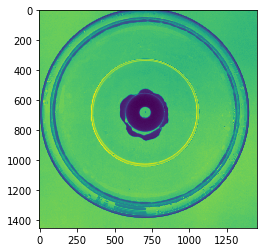

In [7]:
back = BG_tiff(flist, nbckgnd=500)
plt.imshow(back.cbackground)
plt.show()
tiff.imwrite(os.path.join(savepath, "background.tiff"), back.cbackground)
background = back.background


# generate mask

-1


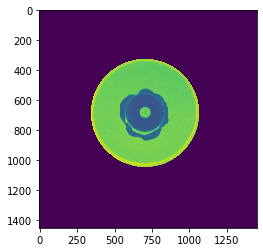

In [8]:
print(back.cir_num)

inner_mask = np.zeros(background.shape)
inner_mask[110:360,100:] = 200
inner_mask = inner_mask>100

outer_mask = np.zeros(background.shape)
outer_mask[360:600,100:] = 200
outer_mask = outer_mask>100

inner_mask = back.gen_cirmask(3)
outer_mask = back.gen_cirmask(2)
plt.imshow(inner_mask*background)

# cutting the image and save

In [9]:
tnum = np.random.randint(len(flist),size=500)
tlist=[]
for s in tnum:
    tlist.append(flist[s])

test = tiff.TiffSequence(tlist).asarray()

outer_mean, outer_std = mean_generater(test, background, outer_mask)
inner_mean, inner_std = mean_generater(test, background, inner_mask)



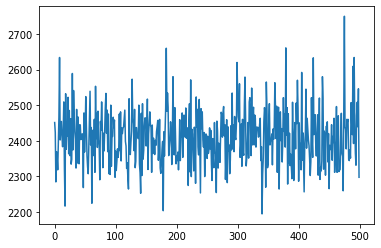

the average number is 2411.184 per img with std = 77.45131466928112
500th op_size:100 ||@size=103.5, pos_err=283.55101866869114, mean=2394.114, std=75.67948866106325
500th op_size:103 ||@size=90.64000000000001, pos_err=0.0, mean=2411.18, std=77.45341567677954
500th op_size:90 ||@size=79.2, pos_err=0.0, mean=2411.162, std=77.43236891636468
500th op_size:90 ||@size=86.9, pos_err=8.0, mean=2410.168, std=76.78817471460043
500th op_size:86 ||@size=75.68, pos_err=0.0, mean=2411.134, std=77.39754546495644
500th op_size:86 ||@size=82.5, pos_err=79.07106781186546, mean=2406.346, std=75.87085266424782
500th op_size:82 ||@size=72.16000000000001, pos_err=0.0, mean=2411.004, std=77.28865365627739
500th op_size:82 ||@size=79.2, pos_err=161.04163056034267, mean=2401.254, std=75.57966316410784
500th op_size:82 ||@size=86.9, pos_err=8.0, mean=2410.168, std=76.78817471460043
500th op_size:82 ||@size=75.68, pos_err=0.0, mean=2411.134, std=77.39754546495644
op_size : 90


In [10]:
#標準差閥值
thres = 13
# size 決定要切成多大
size = optimizer(test, back.background, mask = inner_mask, thres = thres)
print("op_size :",size)
# 每次迴圈處理幾個image(一次讀入的數量，注意記憶體大小)
group_len = 1000   
#原始影片是否為單色
is_mono = back.mono
#影片size(cv格式)
resize = (background.shape[1]//3,background.shape[0]//3)

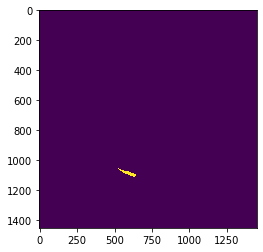

In [11]:
img = tiff.TiffFile(tlist[3]).asarray()
a = img
a = cv2.absdiff(a, background)

temp = a*outer_mask
temp = np.where(temp>(outer_mean+outer_std*thres), 255, 0).astype('uint8')
plt.imshow(temp)

In [ ]:
pos1 = []
pos2 = []
video = cv2.VideoWriter(os.path.join(savepath, "video.avi"),cv2.VideoWriter_fourcc(*'XVID'), 
                        40, resize, isColor=not is_mono)
#video2 = cv2.VideoWriter(os.path.join(savepath, "video2.avi"), cv2.VideoWriter_fourcc(*'ASLC'), 30, (size*2+1,size*2+1))

start = time.time()
num = 0

for s in range(len(flist)//group_len):
    
    imgs = tiff.TiffSequence(flist[s*group_len:(s+1)*group_len]).asarray()
    
    read_time = time.time()
    
    for img in imgs:
        
        if not is_mono:
            a = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        else:
            a = img
        a = cv2.absdiff(a, background)
        
        temp = a*outer_mask
        temp = np.where(temp>(outer_mean+outer_std*thres), 255, 0).astype('uint8')
        pos = get_pos(temp)
        cimg = cutting_img(img, pos, size)
        
        pos1.append(pos)
        tiff.imwrite(os.path.join(savepath,"pos1","frame_"+str(num)+".tiff"),cimg)
        
        temp = a*inner_mask
        temp = np.where(temp>(inner_mean+inner_std*thres), 255, 0).astype('uint8')
        pos = get_pos(temp)
        cimg = cutting_img(img, pos, size)
        
        pos2.append(pos)
        tiff.imwrite(os.path.join(savepath,"pos2","frame_"+str(num)+".tiff"),cimg)
        
        num += 1
        
        video.write(cv2.resize(src=img,dsize=resize))
        
    print((s+1)*group_len, "read time", read_time-start, "write time", time.time()-read_time)
    start = time.time()
        
for filename in flist[(len(flist)//group_len)*group_len:]:
    
    img = tiff.TiffFile(filename).asarray()
    
    if not is_mono:
        a = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        a = img
    a = cv2.absdiff(a, background)

    temp = a*outer_mask
    temp = np.where(temp>(outer_mean+outer_std*thres), 255, 0).astype('uint8')
    pos = get_pos(temp)
    cimg = cutting_img(img, pos, size)

    pos1.append(pos)
    tiff.imwrite(os.path.join(savepath,"pos1","frame_"+str(num)+".tiff"),cimg)

    temp = a*inner_mask
    temp = np.where(temp>(inner_mean+inner_std*thres), 255, 0).astype('uint8')
    pos = get_pos(temp)
    cimg = cutting_img(img, pos, size)

    pos2.append(pos)
    tiff.imwrite(os.path.join(savepath,"pos2","frame_"+str(num)+".tiff"),cimg)

    num += 1

    video.write(cv2.resize(src=img,dsize=resize))
"""
for filename in tiflist:
    a = tiff.TiffFile(path+filename).asarray()
    Cimg = a.copy()
    a = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
    a = cv2.absdiff(a, background)
    in_fish = a*outer_mask
    in_fish = np.where(in_fish>(mean+std*15), 255, 0).astype('uint8')
    _, pos = partial_img(in_fish)
    pos1.append(pos)
    video1.write(cutting_img(Cimg, pos, size))
"""
video.release()
#video2.release()

np.save(os.path.join(savepath, "pos1.npy"), pos1)
np.save(os.path.join(savepath, "pos2.npy"), pos2)

config = {"size": size, "frame_num":frame_num, "version" : "alpha",
          "date": time.strftime("%Y-%m-%d %H:%M", time.localtime()), "shape":background.shape[0:2], "thres":thres, "is_mono":is_mono}

with open(os.path.join(savepath, "save.config"), 'w') as jsonfile:
    json.dump(config, jsonfile, indent=4)

print("end")

1000 read time 6.089186906814575 write time 53.9074125289917


# test for size optimizer